##Imports

In [23]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import cProfile

test = 0

##Function Definitions

In [24]:
def perpendicular_vector(v):
    return [v[0], v[1]]

def point_on_object(point, objects, threshold=10):
    """
    Check if the point is on any of the objects by measuring the distance to each object's points.
    If the distance is less than the threshold, we consider the point to be on the object.

    :param point: The point to check.
    :param objects: The list of objects (clusters of points).
    :param threshold: The distance threshold to consider a point is on the object.
    :return: The index of the object that the point is on, or None if it's on no object.
    """
    for i, obj in enumerate(objects):
        distances = np.linalg.norm(obj - point, axis=1)
        if np.any(distances < threshold):
            return i
    return None



def find_closest_aligned_point(start, direction, objects):
    # Convert start and direction to numpy arrays for vectorized operations
    start = np.array(start)
    direction = np.array(direction)

    # Concatenate all points from all objects into one array
    all_points = np.concatenate(objects)

    # Calculate the y values on the line for all x values
    y_on_line = (direction[1] / direction[0]) * (all_points[:, 0] - start[0]) + start[1]

    # Find points that are close to the line
    close_points = all_points[np.isclose(all_points[:, 1], y_on_line, atol=2)]

    # If there are no close points, return None
    if len(close_points) == 0:
        return None

    # Create vectors from the start point to all close points
    point_vectors = close_points - start

    # Calculate the dot product between the direction vector and all point_vectors
    dot_products = np.dot(point_vectors, direction)

    # Filter points that are in the direction of the vector
    aligned_points = close_points[dot_products > 0]

    # If there are no aligned points, return None
    if len(aligned_points) == 0:
        return None

    # Find the closest point to the start position in the direction of the vector
    distances = np.linalg.norm(aligned_points - start, axis=1)
    closest_point = aligned_points[np.argmin(distances)]

    return closest_point

def find_normal(points, incoming_vector):
    # Compute the centroid of the points
    centroid = np.mean(points, axis=0)

    # Compute the points relative to the centroid
    relative_points = points - centroid

    # Compute the covariance matrix of the relative points
    cov = np.cov(relative_points, rowvar=False)

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # The normal vector is the eigenvector corresponding to the smallest eigenvalue
    normal = eigenvectors[np.argmin(eigenvalues)]
    normal = np.array([-normal[0], normal[1]])  # Swap the components to get (x, y) order

    # Ensure the normal vector points towards the incoming vector
    if np.dot(normal, incoming_vector) > 0:
        normal = -normal  # Reverse the direction of the normal vector

    return normal



##Main Running Code

In [74]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from matplotlib.lines import Line2D

# Load the image and convert to grayscale for obstacle detection
image = cv2.imread('arena.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray, (5, 5))

binary_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]  # Threshold value of 127
if test:
    print(f"test1 none image: {binary_image.shape !=None}")

# Find the black objects using DBSCAN
y_indices, x_indices = np.nonzero(binary_image == 0)
coordinates = np.column_stack([x_indices, y_indices])
db = DBSCAN(eps=2, min_samples=5).fit(coordinates)
labels = db.labels_
if test:   
    print(f"test2 labels : {labels}")

objects = []
for i in np.unique(labels):
    if i != -1:  # Ignore noise
        objects.append(coordinates[labels == i])

# Define the initial position and vector
x = 0
y = int(binary_image.shape[0] / 2)
dx = 50
dy = 250

# y = int(binary_image.shape[0] / 3)
# dx = 10
# dy = 25
start_position = np.array([x, y], dtype=float)
vector = np.array([dx, dy], dtype=float)

# Normalize the vector
vector = normalize(vector.reshape(1, -1))[0]

# Compute the normal vectors for each object
# normals = [find_normal(obj) for obj in objects] //todo
normals = []

profiler = cProfile.Profile()
profiler.enable()
# Find the index of the object that contains the start position
start_object_index = next(i for i, obj in enumerate(objects) if start_position in obj)


# Define the center and radius of the circular area
center = np.array([binary_image.shape[1] // 2, binary_image.shape[0] // 2])
radius = 10

# Initialize the total length
total_length = 0

positions= []
for _ in range(5):
    if test:
        print(f"ITERATION : {_}")
        print(f"init vector:{vector}")
    

    closest_aligned_point = find_closest_aligned_point(start_position, vector, objects)


    if closest_aligned_point is None:
        # If there are no aligned points, break the loop
        print("No Aligned Points ! ")
        break

    # Calculate the distance to the closest aligned point
    distance = np.linalg.norm(closest_aligned_point - start_position)
    total_length += distance

    # WINNER CONDITION
    if np.linalg.norm(start_position - center) <= radius:
        # If it is, break the loop and return the initial starting position, the angle of the vector, and the total length
        angle = np.arctan2(vector[1], vector[0])
        print("##################################### WINNER CONDITION #####################################")
        print(f"Initial starting position: {start_position}, Angle of the vector: {angle}, Length: {total_length}")
        break

    # Move to the closest aligned point
    start_position = closest_aligned_point


    start_object_index = point_on_object(start_position, objects)


    # Assuming normals[start_object_index] is already a normalized normal vector
    normal = find_normal(objects[start_object_index], vector)



    normals.append(normal)

    # Calculate the dot product of the vector and the normal
    dot_prod = np.dot(vector, normal)

    # Calculate the reflected vector
    reflected_vector = vector - 2 * dot_prod * normal

    positions.append(start_position)
    if test:
    
        print(f"start_object_index: {start_object_index}")

        print(f"NORMAL: {normal}")

        print(f"refelcted_vector : {reflected_vector}")

        # Create custom legend entries
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Starting Position', markerfacecolor='red', markersize=10),
            Line2D([0], [0], color='yellow', lw=4, label='Initial Vector'),
            Line2D([0], [0], color='blue', lw=4, label='Reflected Vector'),
            Line2D([0], [0], color='green', lw=4, label='Normal Vector')
        ]

        # Add the legend to the plot with custom entries
        plt.legend(handles=legend_elements, loc='upper right')

        # Draw the point and vector on the image
        plt.imshow(binary_image, cmap='gray')
        plt.scatter(start_position[0], start_position[1], color='red')
        plt.arrow(start_position[0], start_position[1], vector[0]*50, vector[1]*50, color='yellow', head_width=3)
        plt.arrow(start_position[0], start_position[1], reflected_vector[0]*50, reflected_vector[1]*50, color='blue', head_width=3)
        # Draw the normal vector of the object that the start position is on
        plt.arrow(start_position[0], start_position[1], normals[_][0]*50, normals[_][1]*50, color='green', head_width=3)
        plt.pause(0.001)  # Pause to update the figure

    # Update the vector to the reflected vector for the next iteration
    vector = reflected_vector

if test :
    # Keep the plot open
    plt.show()
    
profiler.disable()
profiler.print_stats(sort='time')

         1511 function calls (1461 primitive calls) in 0.006 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       63    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        8    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        5    0.000    0.000    0.001    0.000 function_base.py:2462(cov)
        5    0.000    0.000    0.001    0.000 2185631141.py:22(find_closest_aligned_point)
   143/93    0.000    0.000    0.004    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        5    0.000    0.000    0.001    0.000 2185631141.py:4(point_on_object)
       29    0.000    0.000    0.001    0.000 linalg.py:2349(norm)
        5    0.000    0.000    0.000    0.000 linalg.py:1175(eig)
        5    0.000    0.000    0.000    0.000 numeric.py:2340(within_tol)
        5    0.000    0.000    0.002    0.000 2185631141.py:92(find_normal)
        1    0

[array([ 24, 247], dtype=int64), array([72,  4], dtype=int64), array([84, 66], dtype=int64), array([85, 66], dtype=int64), array([85, 67], dtype=int64)]


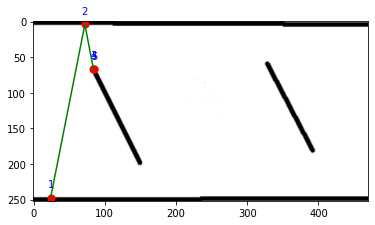

In [75]:
print(positions)
image_rgb = cv2.imread('arena.png')

# Convert the image to RGB (matplotlib expects RGB format)

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_rgb)

# Loop through the positions and plot each one
for i, position in enumerate(positions):
    # Scatter plot for the point
    ax.scatter(position[0], position[1], color='red', s=50)  # s is the size of the point

    # Annotate the point with its number
    ax.annotate(str(i + 1), (position[0], position[1]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    # If not the first point, draw a line from the previous point
    if i > 0:
        # Get the previous point
        prev_position = positions[i - 1]
        # Draw a line from the previous point to the current point
        ax.plot([prev_position[0], position[0]], [prev_position[1], position[1]], color='green')

# Show the plot
plt.show()

##Itreration 360x800x5

In [77]:
print(f"Number of Iterations: {round(image.shape[0]/50)* 5* 360/10} ")

Number of Iterations: 900.0 


In [79]:
# Assuming all the necessary functions and imports are already defined above this code

# Define the center and radius of the circular area
center = np.array([binary_image.shape[1] // 2, binary_image.shape[0] // 2])
radius = 3

# List to store the results
winning_conditions = []

# Iterate over y values from 0 to image height, incrementing by 10 pixels
for y in range(0, binary_image.shape[0],int(binary_image.shape[0]/50)):
    # Iterate over angles from 0 to 360 degrees
    for angle in range(0, 360,5):

        # Convert angle to radians and calculate dx, dy components of the unit vector
        radians = np.radians(angle)
        dx = np.cos(radians)
        dy = np.sin(radians)
        
        # Define the initial position and vector
        start_position = np.array([0, y], dtype=float)
        vector = np.array([dx, dy], dtype=float)
        
        # Normalize the vector
        vector = vector / np.linalg.norm(vector)
        
        # Initialize the total length and number of bounces
        total_length = 0
        bounces = 0

        point_vectors = []

        
        # Perform up to 5 iterations
        for _ in range(5):
            point_vectors.append(start_position)
            closest_aligned_point = find_closest_aligned_point(start_position, vector, objects)
            
            if closest_aligned_point is None:
                # If there are no aligned points, break the loop
                break
            
            # Calculate the distance to the closest aligned point
            distance = np.linalg.norm(closest_aligned_point - start_position)
            total_length += distance
            bounces += 1
            
            # Calculate the direction vector's unit vector
            direction=vector
            direction_unit_vector = direction / np.linalg.norm(direction)

            # Calculate the vector from the start position to the center of the circle
            start_to_center = center - start_position

            # Project start_to_center onto the direction vector
            projection_length = np.dot(start_to_center, direction_unit_vector)
            projection_vector = projection_length * direction_unit_vector

            # Calculate the vector from the center of the circle to the line
            center_to_line = start_to_center - projection_vector

            # Calculate the distance from the center of the circle to the line
            distance_to_line = np.linalg.norm(center_to_line)

            # WINNER CONDITION
            if distance_to_line <= radius:
                # Record the winning condition
                winning_conditions.append({
                    'start_position': start_position.tolist(),
                    'angle': angle,
                    'length': total_length,
                    'bounces': bounces,
                    'points': point_vectors,
                    'fin_vector': vector
                })
                break
            
            # Move to the closest aligned point
            start_position = closest_aligned_point
            
            # Reflect the vector
            normal = find_normal(objects[point_on_object(start_position, objects)], vector)
            dot_prod = np.dot(vector, normal)
            reflected_vector = vector - 2 * dot_prod * normal
            
            # Update the vector to the reflected vector for the next iteration
            vector = reflected_vector




In [69]:
# Print or process the winning conditions as needed
for condition in winning_conditions:
    print(condition)

{'start_position': [103, 98], 'angle': 10, 'length': 891.5316664430702, 'bounces': 5, 'points': [array([ 0., 20.]), array([334,  77], dtype=int64), array([257, 246], dtype=int64), array([147,   6], dtype=int64), array([103,  98], dtype=int64)], 'fin_vector': array([0.97910321, 0.20336397])}
{'start_position': [209, 6], 'angle': 50, 'length': 773.914479575131, 'bounces': 4, 'points': [array([ 0., 20.]), array([139, 184], dtype=int64), array([154, 247], dtype=int64), array([209,   6], dtype=int64)], 'fin_vector': array([0.21753236, 0.97605311])}
{'start_position': [25, 4], 'angle': 330, 'length': 30.68164415931166, 'bounces': 2, 'points': [array([ 0., 20.]), array([25,  4], dtype=int64)], 'fin_vector': array([0.86269317, 0.50572769])}
{'start_position': [151, 247], 'angle': 55, 'length': 265.3671689147501, 'bounces': 2, 'points': [array([ 0., 30.]), array([151, 247], dtype=int64)], 'fin_vector': array([ 0.57096651, -0.82097335])}
{'start_position': [83, 68], 'angle': 20, 'length': 91.664

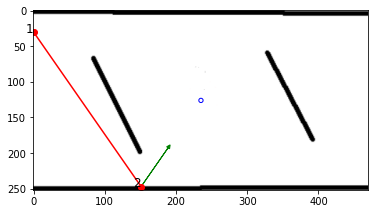

In [70]:
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread('arena.png')

# Plot the image
plt.imshow(img)

# Get the winning condition with the minimum length and minimum number of bounces
winning_condition = winning_conditions[3]

# Get the points and final vector from the winning condition
points = winning_condition['points']
final_vector = winning_condition['fin_vector']

# Plot the points and the lines between them
for i in range(len(points) - 1):
    start = points[i]
    end = points[i + 1]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'ro-')
    plt.text(start[0], start[1], str(i + 1), fontsize=12, ha='right')

# Label the last point
plt.text(points[-1][0], points[-1][1], str(len(points)), fontsize=12, ha='right')

# Draw the final vector from the last point
final_point = points[-1] + winning_condition['length'] * final_vector*0.25
plt.arrow(points[-1][0], points[-1][1], final_point[0] - points[-1][0], final_point[1] - points[-1][1], head_width=5, head_length=5, fc='green', ec='green')

# Draw the central circle
circle = plt.Circle((center[0], center[1]), radius, fill=False, color='blue')
plt.gca().add_patch(circle)

# Display the plot
plt.show()
